<h2>Langkah 1 </h2>

***Data Acquisition***

In [1]:
# 1.1 Import Library
import os
import glob
from matplotlib import pyplot as plt
from PIL import Image

# 1.2 Cek Jumlah Gambar Terlabel
base_path = 'mangga_klasifikasi'
label_dirs = ['stage_0_Unripe', 'stage_1_EarlyRipe', 'stage_2_PartiallyRipe', 'stage_3_Ripe']
random_dir = 'mangga_random'

jumlah_data = {}

for label in label_dirs:
    path = os.path.join(base_path, label)
    gambar = glob.glob(f'{path}/*.jpg')
    jumlah_data[label] = len(gambar)
    
# 1.3 Cek jumlah gambar random
random_images = glob.glob(os.path.join(base_path, random_dir, '*.jpg'))
jumlah_data['Random'] = len(random_images)

# 1.4 Tampilkan ringkasan jumlah data
for k, v in jumlah_data.items():
    print(f"{k}: {v} gambar")

stage_0_Unripe: 238 gambar
stage_1_EarlyRipe: 238 gambar
stage_2_PartiallyRipe: 238 gambar
stage_3_Ripe: 237 gambar
Random: 5 gambar


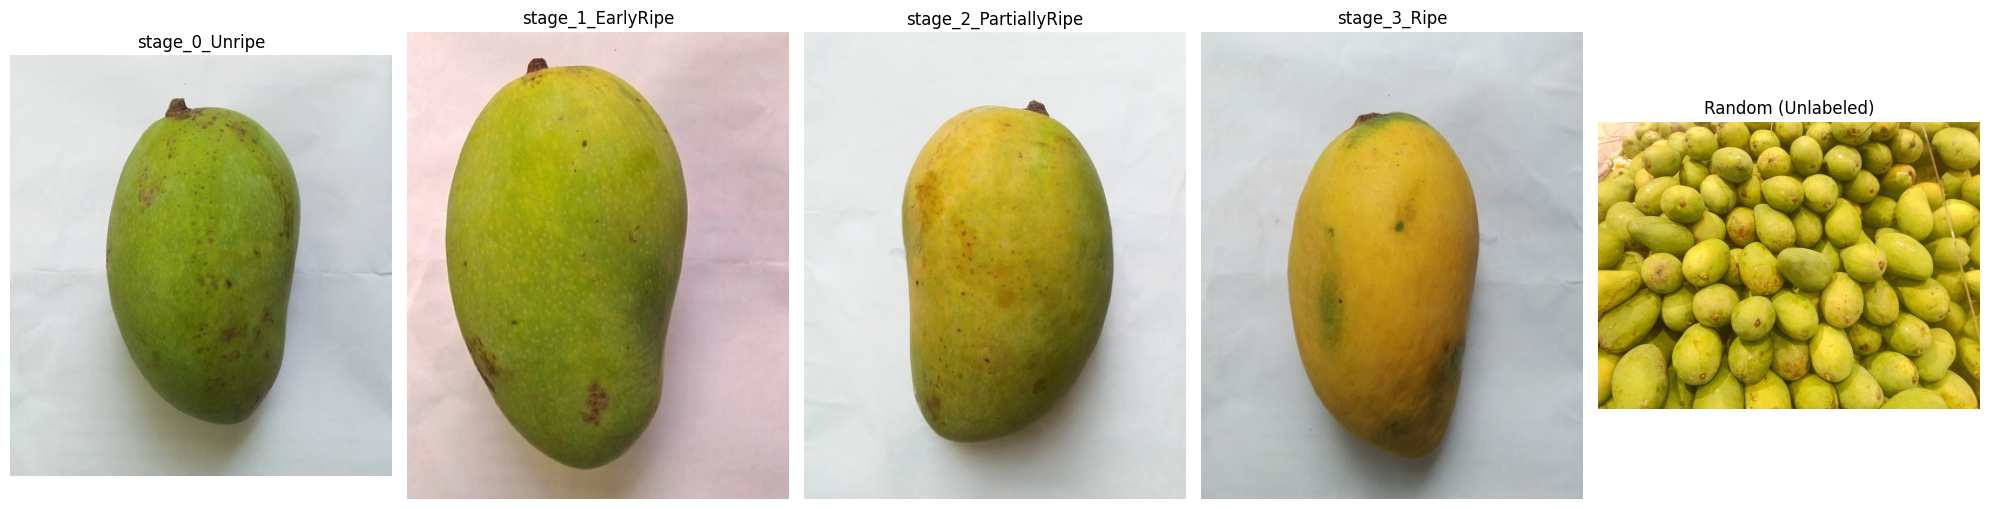

In [2]:
# 1.5 Visualisasi Contoh Gambar
fig, axs = plt.subplots(1, len(label_dirs) + 1, figsize=(20, 5))

for i, label in enumerate(label_dirs):
    path = os.path.join(base_path, label)
    sample_image = glob.glob(f'{path}/*.jpg')[0]
    img = Image.open(sample_image)
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
    
# Gambar random
sample_image = random_images[0]
img = Image.open(sample_image)
axs[-1].imshow(img)
axs[-1].set_title('Random (Unlabeled)')
axs[-1].axis('off')

plt.tight_layout()
plt.show()

<h2>Langkah 2 </h2>

***Data Preprocessing***

In [7]:
import os
from PIL import Image

# Mapping kelas (disesuaikan dengan folder)
label_map = {
    'stage_0_Unripe': 0,
    'stage_1_EarlyRipe': 1,
    'stage_2_PartiallyRipe': 2,
    'stage_3_Ripe': 3,
}

input_folder = 'mangga_klasifikasi'
output_folder = 'yolo_dataset'
os.makedirs(output_folder, exist_ok=True)

for label_folder, class_id in label_map.items():
    image_folder = os.path.join(input_folder, label_folder)
    output_label_folder = os.path.join(output_folder, 'labels', label_folder)
    output_image_folder = os.path.join(output_folder, 'images', label_folder)
    os.makedirs(output_label_folder, exist_ok=True)
    os.makedirs(output_image_folder, exist_ok=True)

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.jpg', '.png')):
            image_path = os.path.join(image_folder, filename)
            img = Image.open(image_path)
            w, h = img.size

            # Otomatis beri bounding box hampir seluruh gambar
            x_center = 0.5
            y_center = 0.5
            width = 0.9
            height = 0.9

            # Simpan file label YOLO
            label_path = os.path.join(output_label_folder, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
            with open(label_path, 'w') as f:
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

            # Salin gambar ke folder output
            img.save(os.path.join(output_image_folder, filename))

print("✅ Anotasi YOLO otomatis selesai.")


✅ Anotasi YOLO otomatis selesai.


<h2>Langkah 3 </h2>

***Feature Extraction (implicit)***

In [8]:
import os
import shutil
import random
from glob import glob
from pathlib import Path

random.seed(42)

# Set direktori hasil anotasi sebelumnya
src_images_dir = 'yolo_dataset/images'
src_labels_dir = 'yolo_dataset/labels'

# Output ke sini
output_dir = 'dataset_split'
for split in ['train', 'valid', 'test']:
    for sub in ['images', 'labels']:
        os.makedirs(os.path.join(output_dir, split, sub), exist_ok=True)

# Proporsi split
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Ambil semua gambar dari semua kelas
all_images = []
for folder in os.listdir(src_images_dir):
    image_files = glob(os.path.join(src_images_dir, folder, '*.jpg'))
    all_images.extend(image_files)

random.shuffle(all_images)

# Hitung split
n = len(all_images)
n_train = int(n * train_ratio)
n_val = int(n * val_ratio)

splits = {
    'train': all_images[:n_train],
    'valid': all_images[n_train:n_train+n_val],
    'test': all_images[n_train+n_val:]
}

# Pindahkan file ke struktur YOLO
for split, image_list in splits.items():
    for image_path in image_list:
        label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
        shutil.copy(image_path, os.path.join(output_dir, split, 'images', Path(image_path).name))
        shutil.copy(label_path, os.path.join(output_dir, split, 'labels', Path(label_path).name))

print("✅ Dataset berhasil dibagi ke train/valid/test")

# Buat file data.yaml
class_names = ['Unripe', 'EarlyRipe', 'PartiallyRipe', 'Ripe']
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    f.write(f"path: {os.path.abspath(output_dir)}\n")
    f.write("train: train/images\n")
    f.write("val: valid/images\n")
    f.write("test: test/images\n")
    f.write(f"names: {class_names}\n")
    f.write(f"nc: {len(class_names)}\n")

print("✅ File data.yaml dibuat.")


✅ Dataset berhasil dibagi ke train/valid/test
✅ File data.yaml dibuat.


<h2>Langkah 4 </h2>

***Training Model YOLOv8***

In [ ]:
from ultralytics import YOLO

# 3.1 Load model YOLOv8 (pilih antara yolov8n.pt, yolov8s.pt, dsb)
model = YOLO("yolov8n.pt")  # yolov8n = nano, ringan dan cepat

# 3.2 Training model
results = model.train(
    data='dataset_split/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='mangga_yolov8_manual',
    project='runs_manual/train',  # default folder
    verbose=True
)


New https://pypi.org/project/ultralytics/8.3.168 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.163  Python-3.10.8 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mangga_yolov8_manual, nbs=64, nms=False, ops

train: Scanning D:\Pemograman\Python\Computer Vision\Terbaru\dataset_split\train\labels.cache... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1.00.1 MB/s, size: 11.1 KB)


val: Scanning D:\Pemograman\Python\Computer Vision\Terbaru\dataset_split\valid\labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]


Plotting labels to runs\train\mangga_yolov8_manual\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\train\mangga_yolov8_manual
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.99G      1.684      3.501      2.109         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         24         24    0.00342          1      0.186     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.01G        1.3      3.322      1.853         19        640: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         24         24    0.00362          1      0.351      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.03G     0.7854      2.973      1.438         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         24         24    0.00341          1       0.34      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.05G      0.561      2.689      1.222         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24         24    0.00334          1      0.353      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.07G     0.5128      2.455      1.172         20        640: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         24         24    0.00326          1      0.446       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.09G     0.4905      2.172      1.086         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         24         24    0.00355          1       0.45      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.1G     0.4499      2.007      1.106         14        640: 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         24         24     0.0036          1      0.582       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.11G     0.4881      1.836      1.069         19        640: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         24         24      0.811       0.25      0.671      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.11G     0.4662      1.753      1.092         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         24         24      0.432      0.641        0.7      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.11G     0.3849      1.537      1.029         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         24         24      0.667      0.593       0.71      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.11G     0.3706      1.539      1.035         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         24         24      0.801      0.573      0.688      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.11G     0.3987      1.551      1.024         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         24         24      0.336      0.958      0.835      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.11G     0.3888      1.469      1.019         22        640: 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         24         24      0.392      0.942      0.671      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.13G     0.4097      1.437      1.047         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         24         24      0.461      0.875      0.698      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.14G      0.418       1.59      1.055         13        640: 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         24         24      0.572      0.933      0.867      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.16G     0.3464      1.403      1.002         21        640: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         24         24      0.448      0.916      0.632      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.18G     0.3519      1.445      1.004         20        640: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         24         24      0.519      0.928      0.738      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.2G     0.3232      1.375      1.004         21        640: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         24         24      0.772          1      0.981      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.21G     0.3721       1.29     0.9948         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         24         24      0.654      0.994      0.959      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.23G      0.311      1.232     0.9691         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         24         24      0.628      0.916      0.877      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.25G      0.366      1.331      1.006         17        640: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         24         24      0.684      0.849       0.83       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.25G     0.3156      1.315     0.9834         15        640: 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         24         24      0.859      0.991      0.954       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.25G     0.3141      1.312      0.978         17        640: 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         24         24      0.802      0.974      0.969      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.25G     0.3112      1.357     0.9977         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         24         24      0.734      0.958      0.944      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.25G     0.3205      1.314      1.013         15        640: 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         24         24      0.754      0.943      0.925      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.25G     0.2984      1.318      0.972         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         24         24      0.677      0.845       0.86       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.25G     0.2823       1.17     0.9515         20        640: 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         24         24      0.728      0.973      0.929      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.25G     0.3005      1.175     0.9882         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         24         24      0.639      0.929      0.918      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.25G     0.3076      1.193     0.9876         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         24         24      0.615      0.974      0.914      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.25G     0.2831      1.168     0.9675         16        640: 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         24         24      0.671      0.997      0.921      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.25G     0.2766      1.089      0.959         15        640: 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         24         24      0.678          1      0.921      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.25G     0.2905      1.195      0.969         21        640: 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         24         24      0.838      0.932      0.964      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.25G     0.3111      1.083     0.9661         24        640: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         24         24      0.981      0.947      0.989      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.25G     0.2925      1.068     0.9736         18        640: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         24         24       0.86      0.872       0.92       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.25G     0.2649      1.049      0.943         16        640: 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         24         24      0.974      0.987      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.25G     0.2709      1.069     0.9702         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         24         24      0.974      0.981      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.25G     0.2407      1.103     0.9437         19        640: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         24         24      0.971      0.985      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.25G     0.2722      1.069     0.9737         14        640: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         24         24      0.846      0.876      0.964      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.25G     0.2676      1.078     0.9665         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         24         24      0.785      0.914      0.917      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.25G     0.2408      1.003      0.944         14        640: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         24         24      0.751      0.903      0.936      0.936


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.25G     0.2826      1.496      1.033          6        640: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         24         24      0.858      0.882      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.25G     0.2688      1.339      1.003          6        640: 100%|██████████| 6/6 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         24         24       0.88      0.889      0.989      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.25G     0.2191       1.48     0.9616          6        640: 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         24         24      0.878      0.947      0.989      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.25G      0.232      1.381      1.026          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         24         24      0.965      0.879      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.25G     0.1898       1.36     0.9286          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         24         24      0.972      0.896      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.25G     0.2091      1.252     0.9518          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         24         24      0.953      0.938      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.25G     0.2147      1.144     0.9881          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         24         24      0.964      0.958      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.25G     0.2153      1.148      1.017          6        640: 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         24         24      0.965      0.958      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.25G     0.2251      1.192      1.008          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         24         24      0.965      0.956      0.985      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.25G     0.2021      1.241     0.9531          6        640: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         24         24      0.961      0.958      0.985      0.985



50 epochs completed in 0.033 hours.
Optimizer stripped from runs\train\mangga_yolov8_manual\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\mangga_yolov8_manual\weights\best.pt, 6.2MB

Validating runs\train\mangga_yolov8_manual\weights\best.pt...
Ultralytics 8.3.163  Python-3.10.8 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


                   all         24         24      0.971      0.985      0.995      0.995
                Unripe          6          6          1      0.938      0.995      0.995
             EarlyRipe          3          3      0.961          1      0.995      0.995
         PartiallyRipe          7          7      0.992          1      0.995      0.995
                  Ripe          8          8       0.93          1      0.995      0.995
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\train\mangga_yolov8_manual


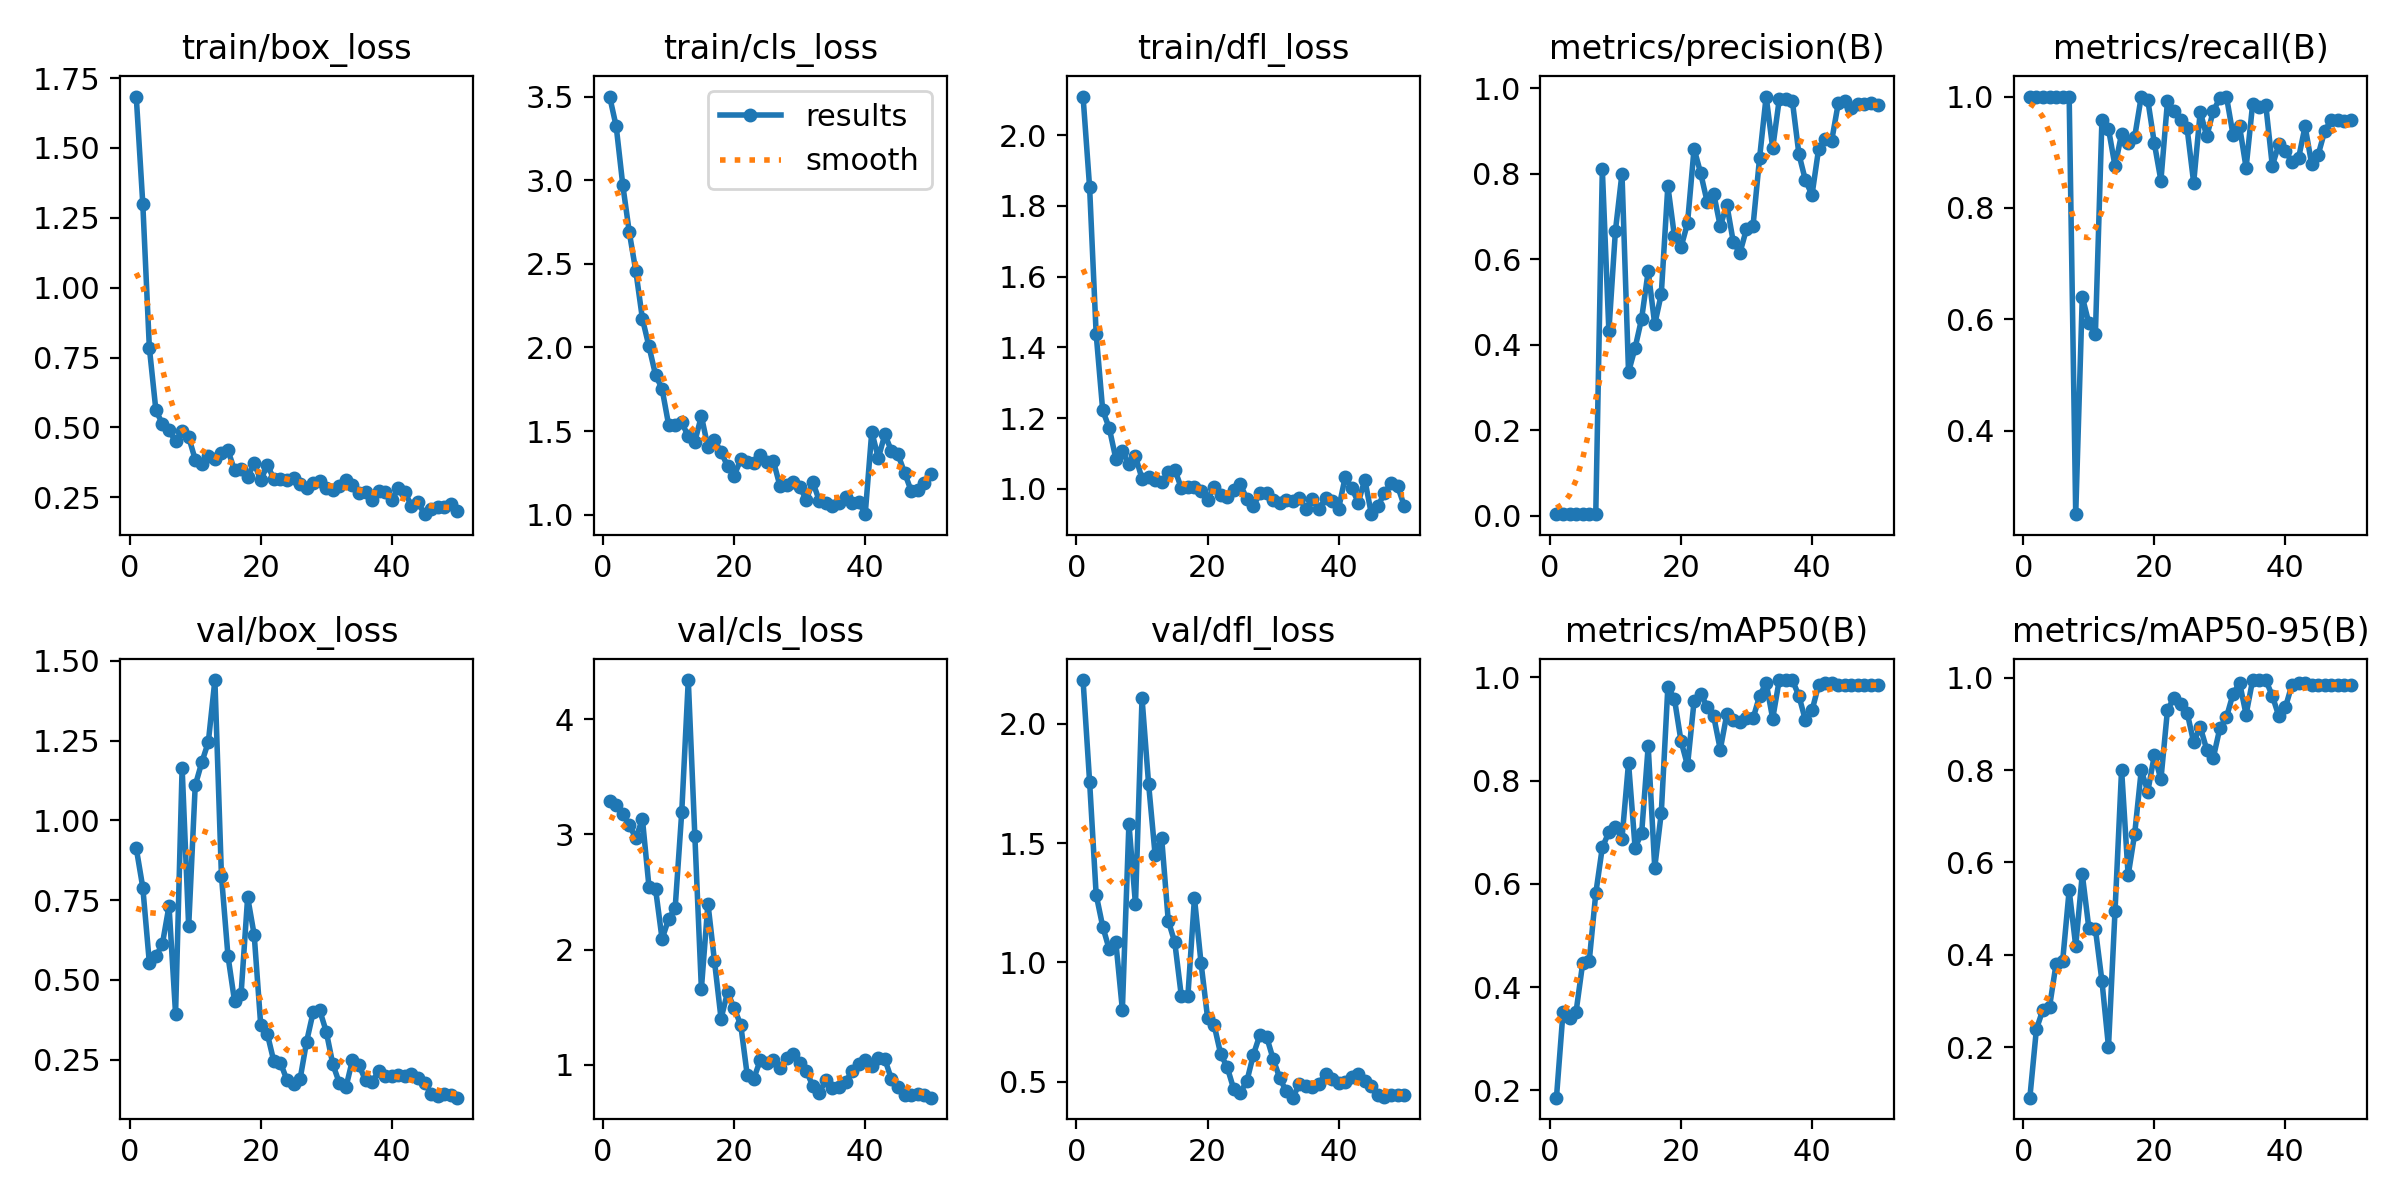

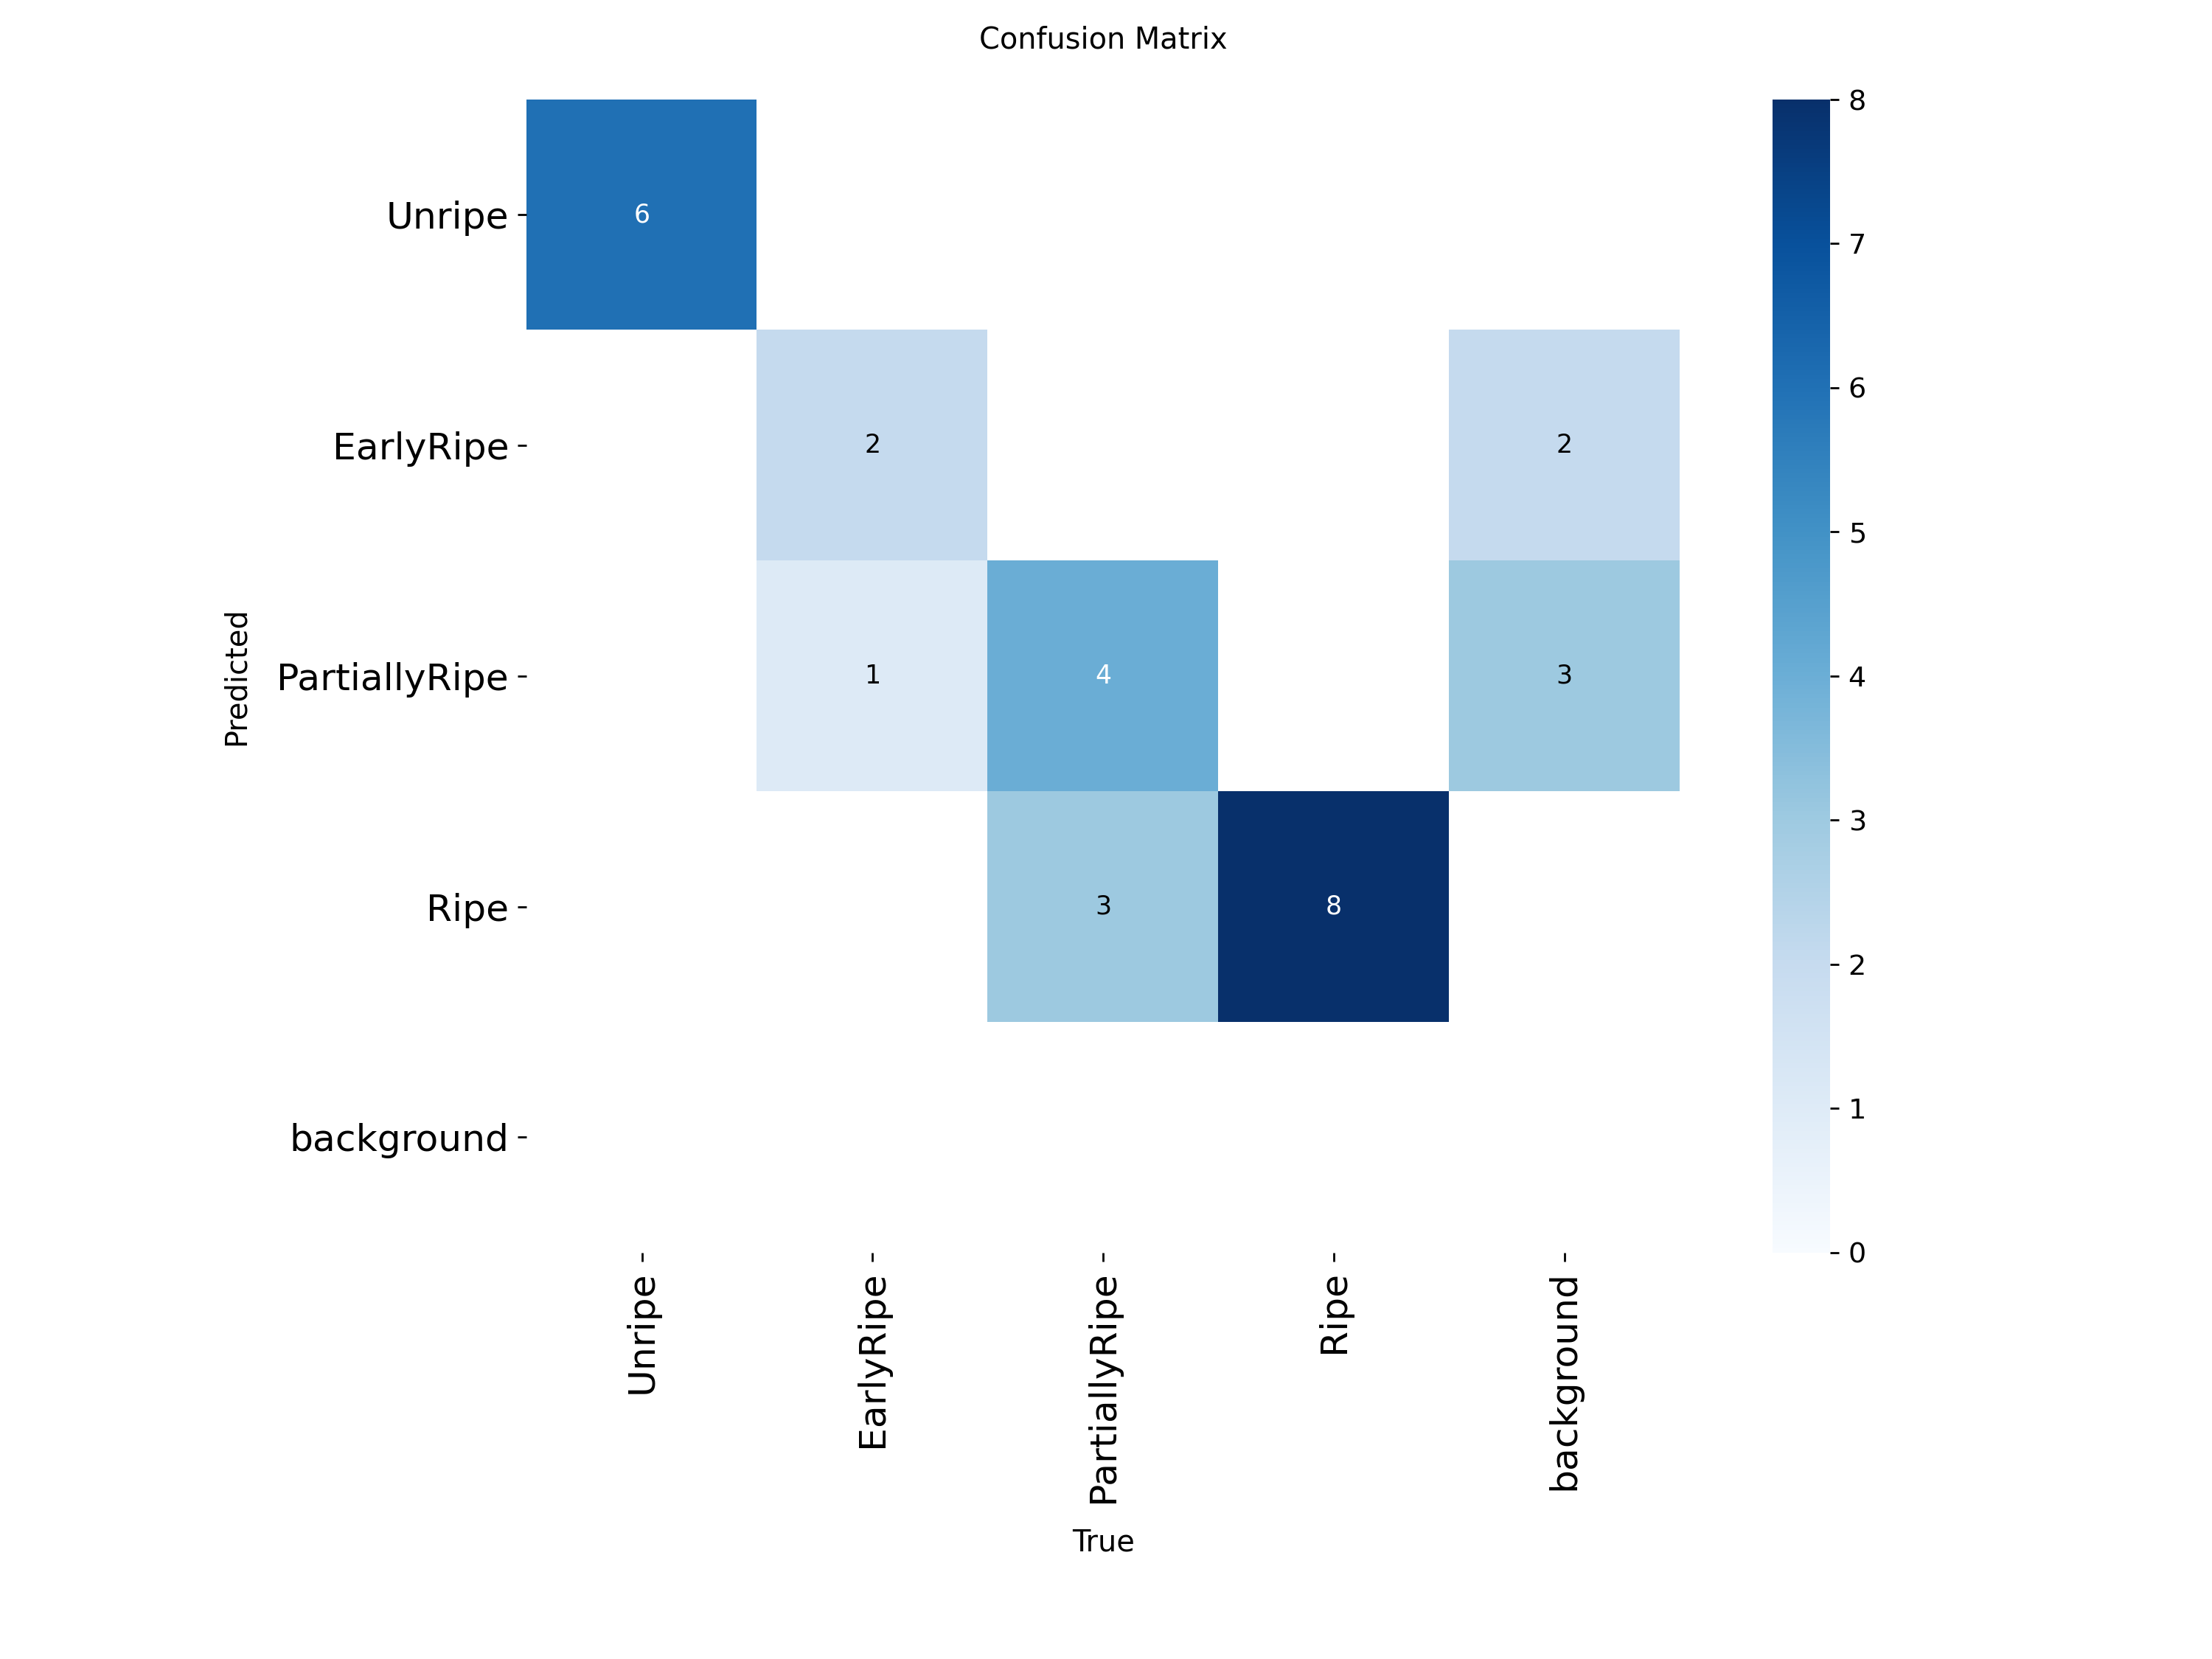

In [ ]:
from IPython.display import Image, display

# 4.1 Tampilkan grafik hasil training
display(Image(filename='runs_manual/train/mangga_yolov8_manual/results.png'))

# 4.2 Tampilkan confusion matrix (jika ada)
conf_matrix_path = 'runs_manual/train/mangga_yolov8_manual/confusion_matrix.png'
if os.path.exists(conf_matrix_path):
    display(Image(filename=conf_matrix_path))


<h2>Langkah 5 </h2>

***Evaluasi Performa Model***

In [ ]:
# 4.3 Evaluasi model best.pt terhadap test set
model = YOLO('runs_manual/train/mangga_yolov8_manual/weights/best.pt')

metrics = model.val(data='dataset_split/data.yaml', split='test')

# 4.4 Cetak metrik evaluasi
print(metrics)


Ultralytics 8.3.163  Python-3.10.8 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 40.79.1 MB/s, size: 9.4 KB)


val: Scanning D:\Pemograman\Python\Computer Vision\Terbaru\dataset_split\test\labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.23s/it]


                   all         14         14      0.906          1      0.995      0.995
                Unripe          6          6      0.927          1      0.995      0.995
             EarlyRipe          2          2      0.969          1      0.995      0.995
         PartiallyRipe          3          3      0.919          1      0.995      0.995
                  Ripe          3          3      0.812          1      0.995      0.995
Speed: 0.3ms preprocess, 3.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002965A5773A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,


image 1/1 d:\Pemograman\Python\Computer Vision\Terbaru\sample\test_mangga12.jpg: 448x640 1 EarlyRipe, 29.8ms
Speed: 2.5ms preprocess, 29.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


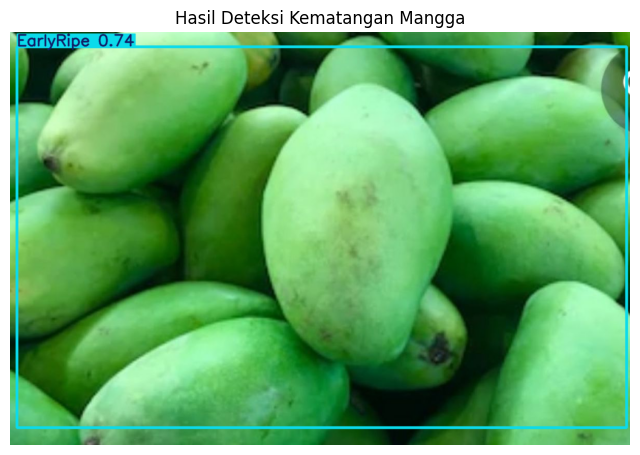

In [ ]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# 5.1 Path gambar uji
uploaded_path = "sample/test_mangga12.jpg"  # Ganti sesuai nama file

# 5.2 Load model terlatih (best.pt dari hasil training)
model = YOLO("runs_manual/train/mangga_yolov8_manual/weights/best.pt")

# 5.3 Lakukan prediksi
results = model.predict(uploaded_path, conf=0.25)

# 5.4 Tampilkan hasil deteksi
for result in results:
    img_result = result.plot()  # gambar dengan bbox
    img = Image.fromarray(img_result[..., ::-1])  # BGR to RGB
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Hasil Deteksi Kematangan Mangga")
    plt.show()
